<a href="https://colab.research.google.com/github/haozhez4/CS441-Final_Project/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Price Fluctuation Prediction Program - Random Forest

[1] Reading stock data...
Data read successfully!
  Period: 2023-01-04 to 2025-11-28
  Stocks: 300 shares
  Records: 209641 entries

[2] Creating prediction features (using previous 10 days of data)...
Feature creation complete! Total 206641 entries

[3] Splitting dataset (80% training, 20% testing)...
  Training set: 165312 entries
  Test set: 41329 entries

[4] Training Random Forest model...
Model training complete! Used 50 features

[5] Model evaluation...
  Training set accuracy: 56.75%
  Test set accuracy: 54.20%

  Test set confusion matrix:
              Predicted Down  Predicted Up
  Actual Down:      21256       873
  Actual Up:      18055      1145

[6] Prediction analysis and return calculation...

  Trading strategy (Buy when probability > 60%):
    Number of trades: 100
    Number of profitable trades: 84
    Win rate:     84.00%
    Average return: +2.12%
    Cumulative return: +211.89%

[7] Saving prediction re

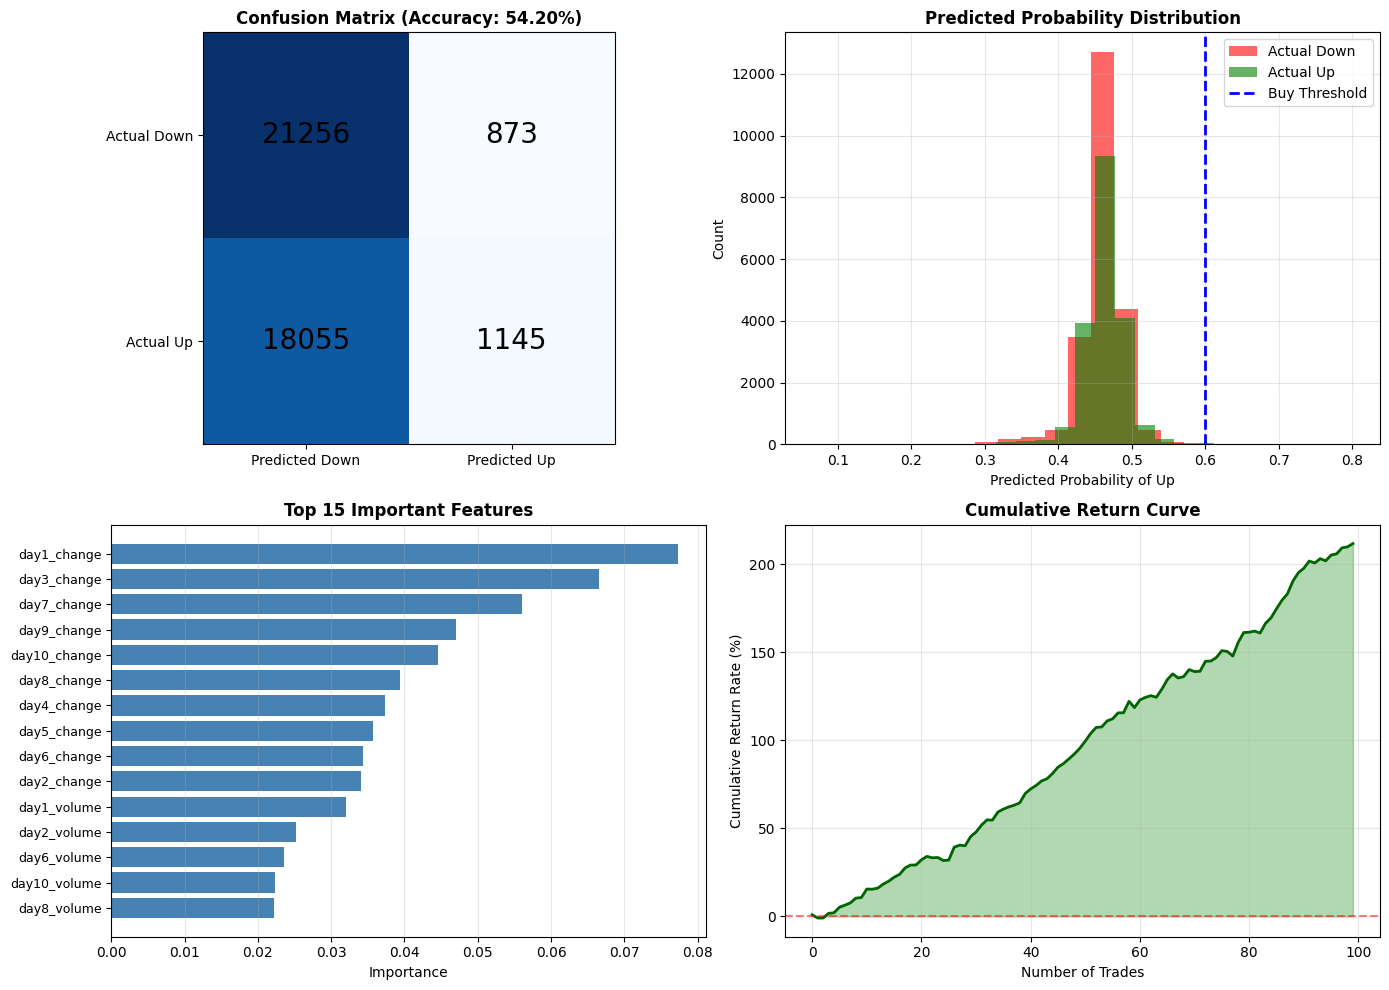

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Stock Price Fluctuation Prediction Program
Author: Claude
Function: Uses the past 10 days of data to predict the next day's price change, using a Random Forest model
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Stock Price Fluctuation Prediction Program - Random Forest")
print("="*70)

# ==================== Step 1: Read Data ====================
print("\n[1] Reading stock data...")

# Please fill in your data file path here
data_file = '/content/drive/MyDrive/CS441 Final/hs300_clean_data.csv'  # ← Modify this to your filename

try:
    # Attempt to read with comma as separator, as it's a CSV file
    df = pd.read_csv(data_file, sep=',')

    df['time'] = pd.to_datetime(df['time'])
    df['change_pct'] = pd.to_numeric(df['change_pct'], errors='coerce')
    df = df.dropna(subset=['change_pct'])

    print(f"Data read successfully!")
    print(f"  Period: {df['time'].min().date()} to {df['time'].max().date()}")
    print(f"  Stocks: {df['code'].nunique()} shares")
    print(f"  Records: {len(df)} entries")

except FileNotFoundError:
    print(f"File not found: {data_file}")
    print("   Please ensure the file is in the current directory, or modify the data_file path above")
    # Removed exit() to allow for further debugging or code execution without terminating the kernel
    # If df is not defined here, subsequent operations will raise a NameError, which is informative.

# ==================== Step 2: Create Features ====================
print("\n[2] Creating prediction features (using previous 10 days of data)...")

df = df.sort_values(['code', 'time']).reset_index(drop=True)
features_list = []
lookback = 10  # Use previous 10 days of data

for stock_code in df['code'].unique():
    stock_df = df[df['code'] == stock_code].reset_index(drop=True)

    # Check if there is enough data
    if len(stock_df) < lookback + 1:
        print(f"{stock_code}: Only {len(stock_df)} days of data, skipping (requires at least {lookback+1} days)")
        continue

    # Create features for each day
    for i in range(lookback, len(stock_df)):
        row = {'code': stock_code, 'date': stock_df.loc[i, 'time']}

        # Extract data for the previous 10 days
        for day in range(1, lookback + 1):
            idx = i - day
            row[f'day{day}_close'] = stock_df.loc[idx, 'close']
            row[f'day{day}_volume'] = stock_df.loc[idx, 'volume']
            row[f'day{day}_change'] = stock_df.loc[idx, 'change_pct']
            row[f'day{day}_high'] = stock_df.loc[idx, 'high']
            row[f'day{day}_low'] = stock_df.loc[idx, 'low']

        # Target: whether it will rise the next day
        row['target'] = 1 if stock_df.loc[i, 'change_pct'] > 0 else 0
        row['next_return'] = stock_df.loc[i, 'change_pct']

        features_list.append(row)

if len(features_list) == 0:
    print("Not enough data! Each stock requires at least 11 consecutive days of data")
    # Removed exit() for same reason as above

df_features = pd.DataFrame(features_list)
print(f"Feature creation complete! Total {len(df_features)} entries")

# ==================== Step 3: Split into Training and Test Sets ====================
print("\n[3] Splitting dataset (80% training, 20% testing)...")

split_idx = int(len(df_features) * 0.8)
train = df_features.iloc[:split_idx]
test = df_features.iloc[split_idx:]

print(f"  Training set: {len(train)} entries")
print(f"  Test set: {len(test)} entries")

# ==================== Step 4: Train Model ====================
print("\n[4] Training Random Forest model...")

# Prepare features and target
feature_cols = [c for c in df_features.columns if c.startswith('day')]
X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

# Create and train the model
model = RandomForestClassifier(
    n_estimators=100,      # 100 trees
    max_depth=10,          # Max depth 10
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print(f"Model training complete! Used {len(feature_cols)} features")

# ==================== Step 5: Evaluate Model ====================
print("\n[5] Model evaluation...")

# Training set accuracy
train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print(f"  Training set accuracy: {train_acc:.2%}")

# Test set accuracy
test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print(f"  Test set accuracy: {test_acc:.2%}")

# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
print(f"\n  Test set confusion matrix:")
print(f"              Predicted Down  Predicted Up")
print(f"  Actual Down:      {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"  Actual Up:      {cm[1,0]:4d}      {cm[1,1]:4d}")

# ==================== Step 6: Predict and Calculate Returns ====================
print("\n[6] Prediction analysis and return calculation...")

# Get prediction probabilities
test['probability'] = model.predict_proba(X_test)[:, 1]
test['predicted'] = test_pred

# Strategy: Buy when probability > 0.6
high_prob = test[test['probability'] > 0.6]

if len(high_prob) > 0:
    wins = (high_prob['next_return'] > 0).sum()
    total = len(high_prob)
    win_rate = wins / total

    avg_return = high_prob['next_return'].mean()
    total_return = high_prob['next_return'].sum()

    print(f"\n  Trading strategy (Buy when probability > 60%):")
    print(f"    Number of trades: {total}")
    print(f"    Number of profitable trades: {wins}")
    print(f"    Win rate:     {win_rate:.2%}")
    print(f"    Average return: {avg_return:+.2f}%")
    print(f"    Cumulative return: {total_return:+.2f}%")
else:
    print("\n No high-probability trading opportunities")

# ==================== Step 7: Save Results ====================
print("\n[7] Saving prediction results...")

# Save prediction details
result_df = test[['date', 'code', 'probability', 'predicted', 'target', 'next_return']].copy()
result_df.columns = ['Date', 'Stock Code', 'Probability of Up', 'Predicted', 'Actual', 'Actual Return Rate']
result_df.to_excel('Prediction_Results.xlsx', index=False)
print(f"  ✓ Prediction results saved to: Prediction_Results.xlsx")

# Save feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df.to_excel('Feature_Importance.xlsx', index=False)
print(f"  ✓ Feature importance saved to: Feature_Importance.xlsx")

# ==================== Step 8: Visualization ====================
print("\n[8] Generating charts...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: Confusion Matrix
ax1 = axes[0, 0]
im = ax1.imshow(cm, cmap='Blues')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Predicted Down', 'Predicted Up'])
ax1.set_yticklabels(['Actual Down', 'Actual Up'])
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm[i, j], ha='center', va='center', fontsize=20)
ax1.set_title(f'Confusion Matrix (Accuracy: {test_acc:.2%})', fontsize=12, fontweight='bold')

# Chart 2: Probability Distribution
ax2 = axes[0, 1]
test_up = test[test['target'] == 1]['probability']
test_down = test[test['target'] == 0]['probability']
ax2.hist(test_down, bins=20, alpha=0.6, color='red', label='Actual Down')
ax2.hist(test_up, bins=20, alpha=0.6, color='green', label='Actual Up')
ax2.axvline(0.6, color='blue', linestyle='--', linewidth=2, label='Buy Threshold')
ax2.set_xlabel('Predicted Probability of Up')
ax2.set_ylabel('Count')
ax2.set_title('Predicted Probability Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Chart 3: Feature Importance (Top 15)
ax3 = axes[1, 0]
top15 = importance_df.head(15).sort_values('Importance')
ax3.barh(range(len(top15)), top15['Importance'], color='steelblue')
ax3.set_yticks(range(len(top15)))
ax3.set_yticklabels(top15['Feature'], fontsize=9)
ax3.set_xlabel('Importance')
ax3.set_title('Top 15 Important Features', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Chart 4: Cumulative Returns
ax4 = axes[1, 1]
if len(high_prob) > 0:
    cumulative = high_prob['next_return'].cumsum()
    ax4.plot(range(len(cumulative)), cumulative, linewidth=2, color='darkgreen')
    ax4.fill_between(range(len(cumulative)), cumulative, 0, alpha=0.3, color='green')
    ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Number of Trades')
    ax4.set_ylabel('Cumulative Return Rate (%)')
    ax4.set_title('Cumulative Return Curve', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No high-probability trades', ha='center', va='center', fontsize=14)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('Analysis_Results_Charts.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Charts saved to: Analysis_Results_Charts.png")

print("\n" + "="*70)
print("Analysis complete!")
print("="*70)
print("\nGenerated Files:")
print("Prediction_Results.xlsx - Daily prediction details")
print("Feature_Importance.xlsx - Feature importance ranking")
print("Analysis_Results_Charts.png - Visualization charts")
print("\n")